In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

In [155]:
def readData(district="Tallinn"):
    # 1. Read and prepare housing data
    data = pd.read_csv("newdata.csv",encoding='latin-1')
    data.date = data.date.astype("str")
    data["date"] = pd.to_datetime(data["date"], format='%m-%Y')
    data = data.replace('-', np.nan)
    data = data.ffill() #Forward Fill 
    data.price = data.price.astype("float")
    data.advertisements = data.advertisements.astype("int")
    data = data.drop(["actives", "city"], axis=1)
    data = data[data.district == district]
    
    # 2. Read and prepare housing loan interest rate data
    dataInterestRate = pd.read_csv("report.csv", delimiter=';',  encoding="latin-1")
    dataInterestRate = dataInterestRate.drop(dataInterestRate.columns[0], axis=1)
    dataInterestRate = dataInterestRate.drop(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,', axis=1)
    dataInterestRate = dataInterestRate.loc[[4]]
    df_melted = pd.melt(dataInterestRate, var_name='date', value_name='interest_rate', ignore_index=False)
    df_melted['interest_rate'] = df_melted['interest_rate'].str.replace(',', '.').str.replace('%', '').astype(float)
    df_melted.reset_index(inplace=True)
    dataInterestRate = dataInterestRate.drop(dataInterestRate.columns[0], axis=1)
    df_melted["date"] = pd.to_datetime(df_melted["date"], format='%m.%Y')
    df_melted = df_melted.drop("index", axis=1)
    
    # 3. Read and prepare income data from first file
    incomeData1 = pd.read_csv("kuupalk2007-2018.csv", skiprows=2,encoding='latin-1')
    incomeData1['Maakond'] = incomeData1['Maakond'].replace({'..Tallinn': 'Tallinn', 'Tartu maakond': 'Tartu'})
    incomeData1.rename(columns={'Keskmine brutokuupalk, eurot': 'salary'}, inplace=True)
    incomeData1.rename(columns={'Maakond': 'district'}, inplace=True)
    incomeData1.rename(columns={'Aasta': 'year'}, inplace=True)
    incomeData1.rename(columns={'Keskmise brutokuupalga juurdekasvutempo vÃµrreldes eelmise perioodiga, %': 'difference'}, inplace=True)
    incomeData1 = incomeData1[incomeData1.district == district]
    #incomeData1['difference'] = incomeData1['difference'].astype(float)

    kvartal_mapping = {'I kvartal': 1, 'II kvartal': 2, 'III kvartal': 3, 'IV kvartal': 4}
    incomeData1['Kvartal'] = incomeData1['Kvartal'].map(kvartal_mapping)
    incomeData1['year'] = incomeData1['year'].astype(int)

    # Create a new DataFrame with 12 months for each year
    expanded_dates = pd.DataFrame({
        'year': np.repeat(incomeData1['year'].unique(), 12),
        'month': np.tile(np.arange(1, 13), len(incomeData1['year'].unique()))
    })

    # Map each month to its corresponding quarter
    month_to_quarter = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4}
    expanded_dates['Kvartal'] = expanded_dates['month'].map(month_to_quarter)

    # Merge the expanded_dates DataFrame with the original DataFrame
    result_df = pd.merge(expanded_dates, incomeData1, on=['year', 'Kvartal'], how='left')

    # Forward fill the values for 'district', 'salary', and 'difference'
    result_df[['district', 'salary', 'difference']] = result_df[['district', 'salary', 'difference']].ffill()
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))
    result_df = result_df.drop(["Kvartal", "year", "month"], axis=1)
    result_df["date"] = pd.to_datetime(result_df["date"], format='%Y-%M')

    # 4. Read and prepare income data from second file
    incomeData2 = pd.read_csv("kuupalk2018-2022.csv", skiprows=2,encoding='latin-1')
    incomeData2 = incomeData2.drop(index=range(4)) # Starts from 2018, already have these values
    incomeData2['Maakond'] = incomeData2['Maakond'].replace({'Tartu maakond': 'Tartu'})
    incomeData2.rename(columns={'Maakond': 'district','Keskmise brutokuupalga muutus vÃµrreldes eelmise perioodiga, %': 'difference', "Keskmine brutokuupalk, eurot":"salary"}, inplace=True)
    incomeData2.rename(columns={'Maakond': 'district'}, inplace=True)
    incomeData2['difference'] = incomeData2['difference'].replace("..", 6.6)
    incomeData2[['year', 'quartile']] = incomeData2['Vaatlusperiood'].str.split(' ', n=1, expand=True)
    quartile_to_int = {'I kvartal': 1, 'II kvartal': 2, 'III kvartal': 3, 'IV kvartal': 4}
    incomeData2['quartile'] = incomeData2['quartile'].map(quartile_to_int)
    incomeData2['year'] = incomeData2['year'].astype(int)
    incomeData2 = incomeData2.drop("Vaatlusperiood", axis=1)
    incomeData2['difference'] = incomeData2['difference'].astype(float)
    incomeData2 = incomeData2[incomeData2['district'] == district]

    # Create a new DataFrame with 12 months for each year
    expanded_dates = pd.DataFrame({
        'year': np.repeat(incomeData2['year'].unique(), 12),
        'month': np.tile(np.arange(1, 13), len(incomeData2['year'].unique()))
    })

    expanded_dates['quartile'] = expanded_dates['month'].map(month_to_quarter)

    # Merge the expanded_dates DataFrame with the original DataFrame
    result_df2 = pd.merge(expanded_dates, incomeData2, on=['year', 'quartile'], how='left')

    # Forward fill the values for 'district', 'salary', and 'difference'
    result_df2[['district', 'salary', 'difference']] = result_df2[['district', 'salary', 'difference']].ffill()
    result_df2['date'] = pd.to_datetime(result_df2[['year', 'month']].assign(day=1))
    result_df2 = result_df2.drop(["year", "month", "quartile"], axis=1)
    result_df2["date"] = pd.to_datetime(result_df2["date"], format='%Y-%M')

    # Merge both salary dataframes together
    data_salary = pd.merge(result_df, result_df2, on=None, how='outer')
    data_salary = data_salary.sort_values('date')  # Sort the merged DataFrame by the 'date' column
    data_salary = data_salary.drop(["district"], axis=1)
    
    # 5. Merge the datasets
    df_merged = pd.merge(data, df_melted, on='date', how='left')
    df_merged = pd.merge(df_merged, data_salary, on='date', how='left')
    
    return df_merged

In [156]:
data = readData("Tallinn")
data = data.dropna(subset=["salary"]) # Since one time series dataset ended a year earlier, we have to remove those values
data.head()

,date,district,price,advertisements,interest_rate,salary,difference
0,2007-05-01,Tallinn,1993.2,7252,5.63,840.0,8.0
1,2007-06-01,Tallinn,1948.8,7405,5.65,840.0,8.0
2,2007-07-01,Tallinn,1935.0,7644,5.87,799.0,-4.9
3,2007-08-01,Tallinn,1922.1,7945,5.98,799.0,-4.9
4,2007-09-01,Tallinn,1912.4,8476,6.09,799.0,-4.9


In [165]:
# Normalize the dataset
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_advertisements = MinMaxScaler(feature_range=(0, 1))
scaler_interest_rate = MinMaxScaler(feature_range=(0, 1))

scaled_price = scaler_price.fit_transform(data[['price']])
scaled_advertisements = scaler_advertisements.fit_transform(data[['advertisements']])
scaled_interest_rate = scaler_interest_rate.fit_transform(data[['interest_rate']])

scaled_data = np.concatenate((scaled_price, scaled_advertisements, scaled_interest_rate, data[['difference']]), axis=1)


# Split the data into training set and test set
train_length = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length-60:,:]

# Create the training data set
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,:]) # For every row take the values for past 60 rows
    y_train.append(train_data[i,0]) # Actual price 
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))

# Create the testing data set
x_test = []
y_test = data.iloc[train_length:, :]['price']
test_data_len = len(test_data)

for i in range(60, test_data_len):
    x_test.append(test_data[i-60:i, :])

# Convert the data to a numpy array
x_test = np.array(x_test)


In [192]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 4)))
model.add(LSTM(60, return_sequences=True))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(50))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=180)

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler_price.inverse_transform(predictions) # Undo scaling

Epoch 1/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0854
Epoch 2/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0474
Epoch 3/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0293
Epoch 4/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0160
Epoch 5/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0224
Epoch 6/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0187
Epoch 7/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0112
Epoch 8/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0099
Epoch 9/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0119
Epoch 10/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0094
Epoch 11/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0056
Epoch 12/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0063
Epoch 13/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0064
Epoch 14/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0033
Epoch 15/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0024
Epoch 16/180
2/2 ━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8.2446e-05
Epoch 81/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 8.1957e-05
Epoch 82/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8.2158e-05
Epoch 83/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 8.0917e-05
Epoch 84/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 7.7011e-05
Epoch 85/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 8.6187e-05
Epoch 86/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 8.1882e-05
Epoch 87/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8.2572e-05
Epoch 88/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 7.9404e-05
Epoch 89/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 7.5343e-05
Epoch 90/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 7.6579e-05
Epoch 91/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 7.3249e-05
Epoch 92/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 7.7681e-05
Epoch 93/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 7.7171e-05
Epoch 94/180
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.2598e-05
Epoch 159/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.5470e-05
Epoch 160/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.5952e-05
Epoch 161/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.5470e-05
Epoch 162/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 4.4693e-05
Epoch 163/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.4938e-05
Epoch 164/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.7203e-05
Epoch 165/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 4.5632e-05
Epoch 166/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 4.5196e-05
Epoch 167/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.4107e-05
Epoch 168/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 4.3222e-05
Epoch 169/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 4.3240e-05
Epoch 170/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.5983e-05
Epoch 171/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 4.5062e-05
Epoch 172/180
2/2 ━

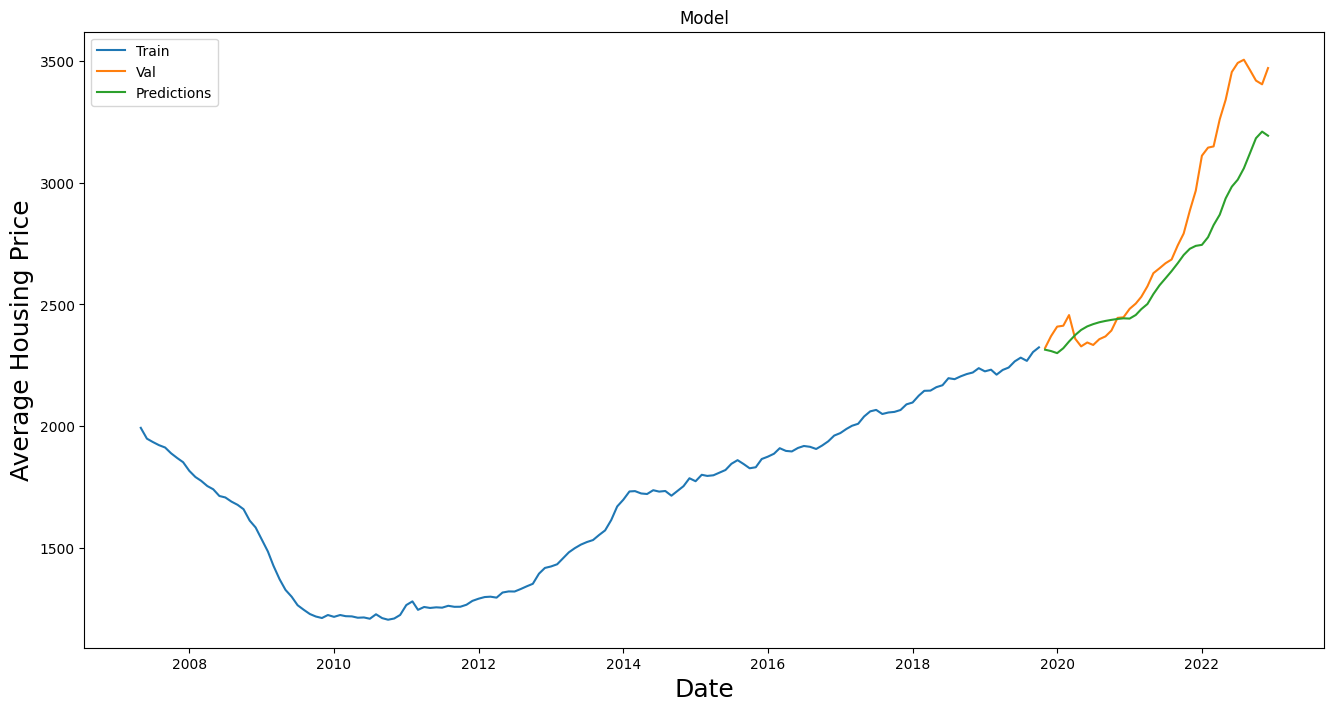

In [193]:
# Plot the data
train = data[:train_length]
valid = data[train_length:].copy()
valid.loc[:, 'Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Average Housing Price', fontsize=18)
plt.plot(train["date"], train['price'])
plt.plot(valid["date"], valid[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()